In [2]:
from packages import *

In [3]:
data_path = '../DATA/Ruby/'
xlim = [690, 695]
def get_data(T):
  background = pd.read_csv(data_path + f'{T}K_Bac.asc', skiprows=26, names=['Wavelength[nm]', 'Intensity[a.u.]'])
  reference = pd.read_csv(data_path + f'{T}K_Ref.asc', skiprows=26, names=['Wavelength[nm]', 'Intensity[a.u.]'])
  signal = pd.read_csv(data_path + f'{T}K_Sig.asc', skiprows=26, names=['Wavelength[nm]', 'Intensity[a.u.]'])
  mask = (signal['Wavelength[nm]'] > xlim[0]) & (signal['Wavelength[nm]'] < xlim[1])
  signal = signal[mask]
  reference = reference[mask]
  background = background[mask]
  return reference, background, signal


In [119]:
T = 110
ref, bac, sig = get_data(T)

# Curve Fit

[3.29675150e+05 6.83869363e+02 1.30892069e-01 1.63225678e+03
 6.92858840e+02 8.93172713e-02]


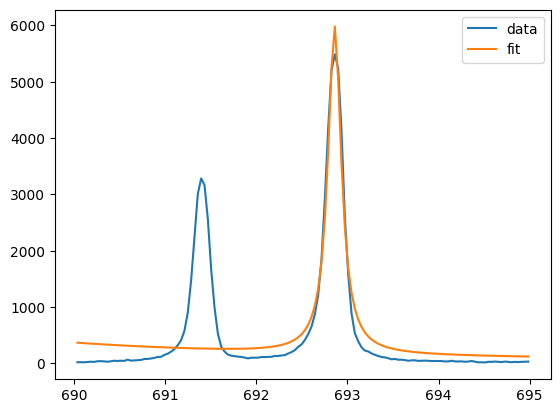

In [120]:
x = ref['Wavelength[nm]']
y = ref['Intensity[a.u.]']

func = lambda x, A1, x1, L1, A2, x2, L2: A1 / np.pi * L1 / (L1**2 + (x - x1)**2) + A2 / np.pi * L2 / (L2**2 + (x - x2)**2)
p0 = [1, 690, 10, 10, 694, 10]

popt, pcov = scipy.optimize.curve_fit(func, x, y, p0=p0)
print(popt)

plt.plot(x, y, label='data')
plt.plot(x, func(x, *popt), label='fit')
plt.legend()

# Torch Fitting

RMSE Error :  203.69966000419544
Peak1 : 606.00, Centre1 : 691.34, Width1 : 0.07, Area1 : 14.47
Peak2 : 7427.00, Centre2 : 692.80, Width2 : 0.08, Area2 : 188.64
Ratio : 0.08
R2 : 0.97


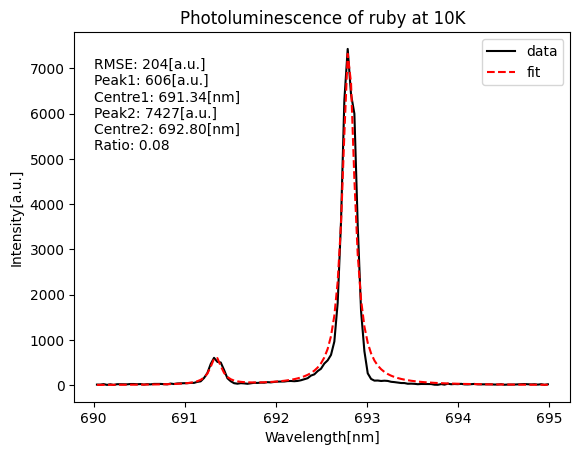

[10,
 606.0,
 array(691.34147369),
 array(0.07499781),
 14.466761830405398,
 7427.0,
 array(692.79783524),
 array(0.07979277),
 188.63708242562603,
 0.07669097530762123]

In [28]:
def fit(T, log=False, plot=False, save=False):
  ref, bac, sig = get_data(T)
  x = th.tensor(ref['Wavelength[nm]'].to_numpy())
  y = th.tensor(ref['Intensity[a.u.]'].to_numpy(), dtype=th.float32)

  # peak finding
  range1 = [690, 692]; range2 = [692, 695]
  mask1 = (x > range1[0]) & (x < range1[1]); mask2 = (x > range2[0]) & (x < range2[1])
  y1 = y[mask1]; y2 = y[mask2]
  peak1 = th.max(y1); peak2 = th.max(y2)
  A1 = peak1; x1 = x[mask1][th.argmax(y1)]; L1 = 0.1
  A2 = peak2; x2 = x[mask2][th.argmax(y2)]; L2 = 0.1

  # fitting
  func = lambda x, x1, L1, x2, L2: A1 * L1**2 / (L1**2 + (x - x1)**2) + A2 * L2**2 / (L2**2 + (x - x2)**2)
  p0 = th.tensor([x1, L1*1e2, x2, L2*1e2], requires_grad=True)
  params = th.tensor([1, 1e-2, 1, 1e-2], requires_grad=True)

  optimizer = th.optim.Adam([params], lr=5e-4, weight_decay=1e-5)

  for epoch in range(1000):
    optimizer.zero_grad()
    loss = th.mean((func(x, *(p0*params)) - y)**2)
    loss.backward()
    optimizer.step()
  if log:
    print('RMSE Error : ', np.sqrt(loss.item()))
  result = (params*p0)

  peak1 = A1.item(); peak2 = A2.item()
  mid1 = result[0].detach().numpy(); mid2 = result[2].detach().numpy()
  width1 = result[1].detach().numpy(); width2 = result[3].detach().numpy()
  area1 = A1.item()*result[1].detach().numpy() / np.pi; area2 = A2.item()*result[3].detach().numpy() / np.pi
  ratio = (A1.item()*result[1].detach().numpy() / np.pi) / (A2.item()*result[3].detach().numpy() / np.pi)
  R2 = 1 - loss.item() / ((y - y.mean())**2).mean()

  if log:
    print(f'Peak1 : {peak1:.2f}, Centre1 : {mid1:.2f}, Width1 : {width1:.2f}, Area1 : {area1:.2f}')
    print(f'Peak2 : {peak2:.2f}, Centre2 : {mid2:.2f}, Width2 : {width2:.2f}, Area2 : {area2:.2f}')
    print(f'Ratio : {ratio:.2f}')
    print(f'R2 : {R2:.2f}')
  if plot or save:
    plt.plot(x, y, label='data', color='black')
    plt.plot(x, func(x, *(p0*params).detach().numpy()), label='fit', color='red', linestyle='--')
    plt.title(f'Photoluminescence of ruby at {T}K')
    plt.xlabel('Wavelength[nm]')
    plt.ylabel('Intensity[a.u.]')
    plt.text(690, peak2*0.7, f"""RMSE: {np.sqrt(loss.item()):.0f}[a.u.]
Peak1: {peak1:.0f}[a.u.]
Centre1: {mid1:.2f}[nm]
Peak2: {peak2:.0f}[a.u.]
Centre2: {mid2:.2f}[nm]
Ratio: {ratio:.2f}""")
    plt.legend()
    if save:
      plt.savefig(f'output/Ruby_Fit/{T}K.png', dpi=400)
    if plot:
      plt.show()
    plt.close()
  return [T, peak1, mid1, width1, area1, peak2, mid2, width2, area2, ratio]

In [33]:
data = []
Temperature = np.arange(10, 300, 10)
for T in Temperature:
  data.append(fit(T, log=False, plot=False, save=True))
data = np.array(data)
data.shape

(29, 10)

RMSE Error :  150.34649429191862
Peak1 : 3284.00, Centre1 : 691.39, Width1 : 0.10, Area1 : 99.46
Peak2 : 5489.00, Centre2 : 692.85, Width2 : 0.10, Area2 : 177.76
Ratio : 0.56
R2 : 0.98


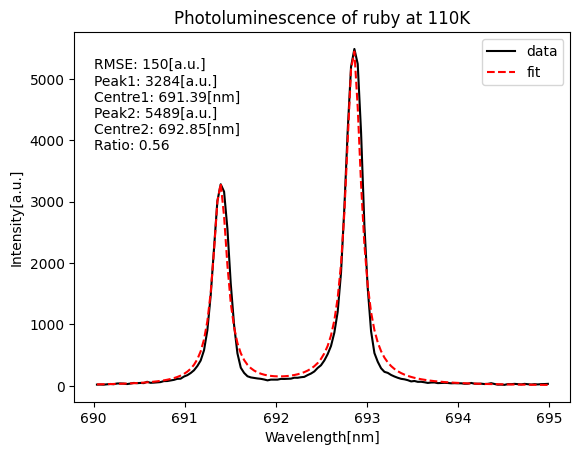

[110,
 3284.0,
 array(691.38888329),
 array(0.09514323),
 99.45604541446275,
 5489.0,
 array(692.85098297),
 array(0.10173945),
 177.75946446782464,
 0.5594978906592329]

In [34]:
fit(110, log=True, plot=True, save=False)

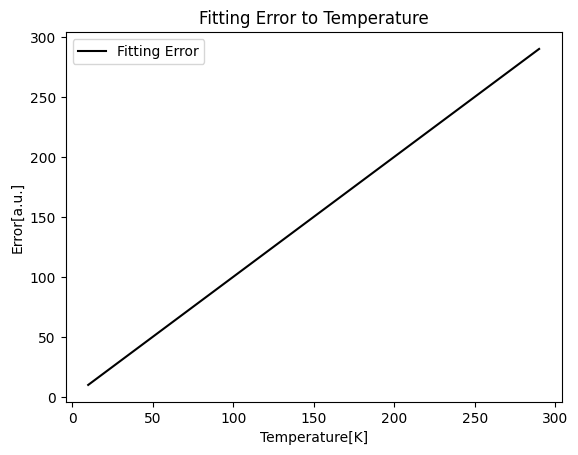

In [52]:
plt.title('Fitting Error to Temperature')
plt.plot(Temperature, data[:, 0], label='Fitting Error', color='black')
plt.xlabel('Temperature[K]')
plt.ylabel('Error[a.u.]')
plt.legend()
plt.savefig('output/Ruby_EDA/Error.png', dpi=400)
plt.show()

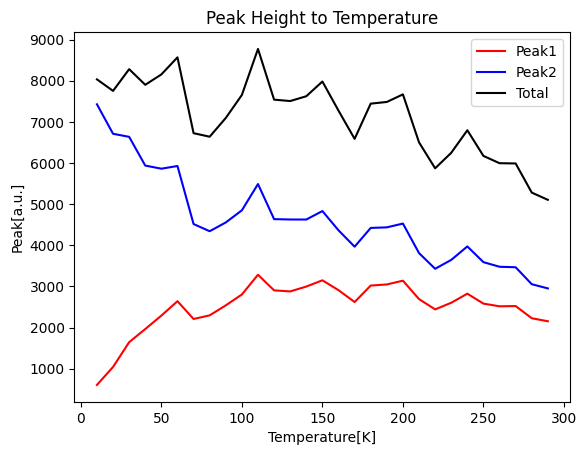

In [53]:
plt.title('Peak Height to Temperature')
plt.plot(Temperature, data[:, 1], label='Peak1', color='red')
plt.plot(Temperature, data[:, 5], label='Peak2', color='blue')
plt.plot(Temperature, data[:, 1] + data[:, 5], label='Total', color='black')
plt.xlabel('Temperature[K]')
plt.ylabel('Peak[a.u.]')
plt.legend()
plt.savefig('output/Ruby_EDA/Peak.png', dpi=400)
plt.show()

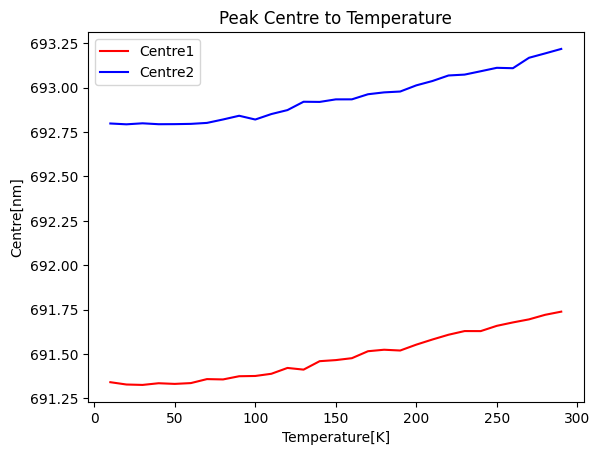

In [54]:
plt.title('Peak Centre to Temperature')
plt.plot(Temperature, data[:, 2], label='Centre1', color='red')
plt.plot(Temperature, data[:, 6], label='Centre2', color='blue')
plt.xlabel('Temperature[K]')
plt.ylabel('Centre[nm]')
plt.legend()
plt.savefig('output/Ruby_EDA/Centre.png', dpi=400)
plt.show()

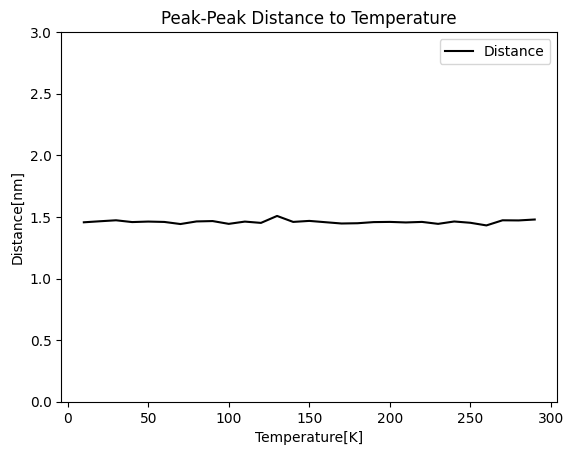

In [55]:
plt.title('Peak-Peak Distance to Temperature')
plt.plot(Temperature, - data[:, 2] + data[:, 6], label='Distance', color='black')
plt.xlabel('Temperature[K]')
plt.ylabel('Distance[nm]')
plt.ylim(0, 3)
plt.legend()
plt.savefig('output/Ruby_EDA/Distance.png', dpi=400)
plt.show()

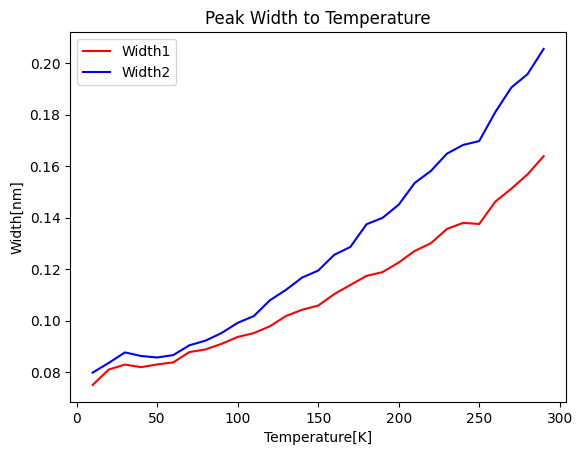

In [56]:
plt.title('Peak Width to Temperature')
plt.plot(Temperature, data[:, 3], label='Width1', color='red')
plt.plot(Temperature, data[:, 7], label='Width2', color='blue')
plt.xlabel('Temperature[K]')
plt.ylabel('Width[nm]')
plt.legend()
plt.savefig('output/Ruby_EDA/Width.png', dpi=400)
plt.show()

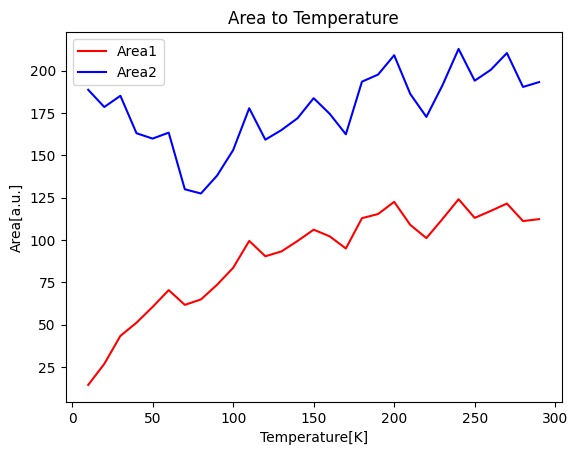

In [57]:
plt.title('Area to Temperature')
plt.plot(Temperature, data[:, 4], label='Area1', color='red')
plt.plot(Temperature, data[:, 8], label='Area2', color='blue')
plt.xlabel('Temperature[K]')
plt.ylabel('Area[a.u.]')
plt.legend()
plt.savefig('output/Ruby_EDA/Area.png', dpi=400)
plt.show()

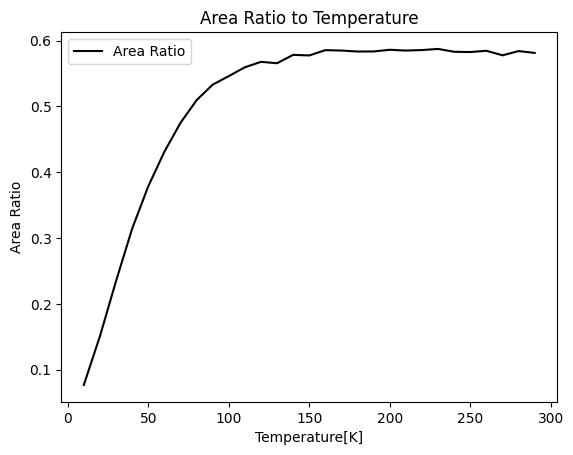

In [58]:
plt.title('Area Ratio to Temperature')
plt.plot(Temperature, data[:, 9], label='Area Ratio', color='black')
plt.xlabel('Temperature[K]')
plt.ylabel('Area Ratio')
plt.legend()
plt.savefig('output/Ruby_EDA/Ratio.png', dpi=400)
plt.show()